## 0. Introduction

The aim of this lab is to get familiar with **classification problems** and **logistic regression**. We will be using some code extracts that were implemented last week and build a logistic regression model.

1.   This lab is the second course-work activity **Assignment 1 Part 2: Classification**
2. Assignment 1 is split into 3 parts: Part 1 - Regression (Lab 3), and Part 2 - Classification (Lab 4) and Part 3 - Neural Networks (Lab 6). The three parts need to be submitted together by  **Monday, 11th November 2024, 10:00am**
3. All questions need to be completed and are assessed.
4. For each lab, a report answering the <font color = 'red'>**questions in red**</font> should be included along with the completed Notebook (.ipynb)
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.).
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. There are three parts of Assignment 1, therefore you should submit a zip file that contains 1 x Notebook and 1 x PDF for each part. In total: 3 x Notebooks and 3 x PDFs in the submission zip. Make sure the file is well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
7. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
8. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display
import numpy as np
import torch.nn.functional as F



import typing
%matplotlib inline

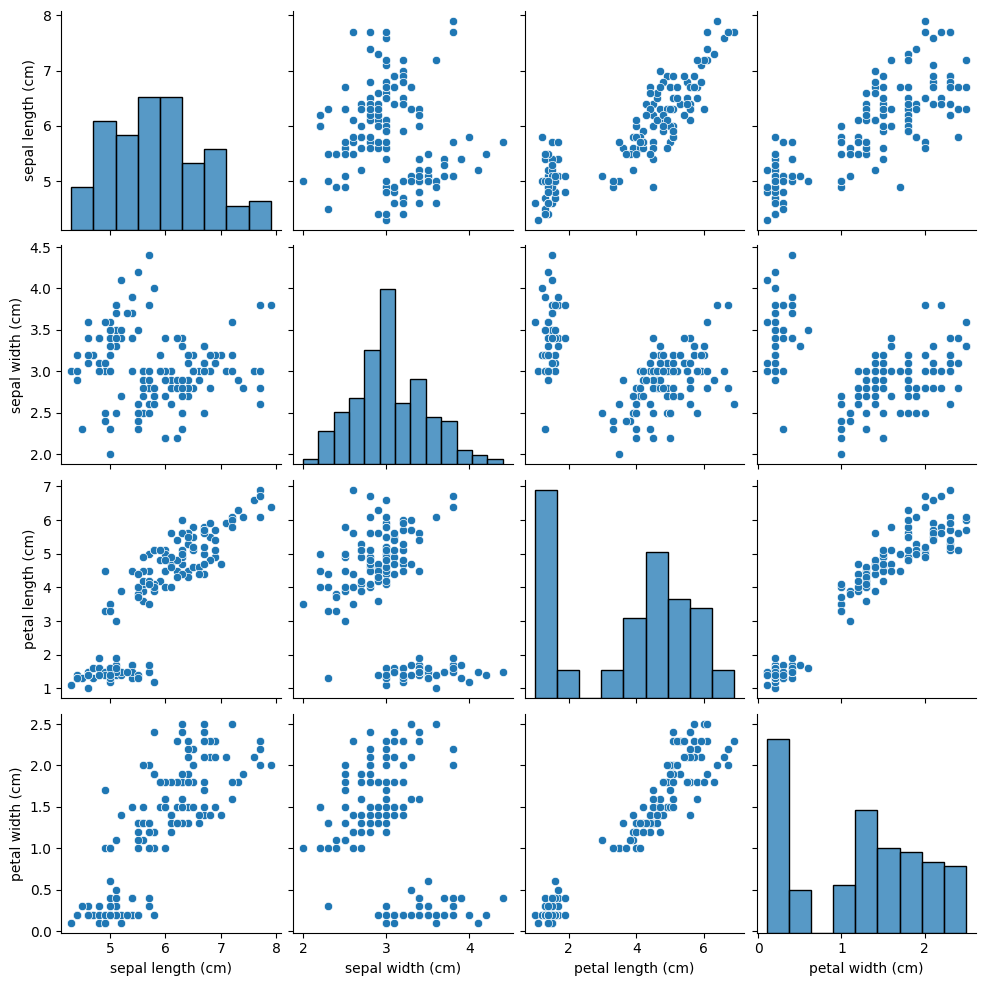

In [2]:
iris_db = datasets.load_iris(as_frame=True)
sn.pairplot(iris_db.data)

In [3]:
#iris_db.data.iloc[:,[0]]
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

<font color="red">**Q1.** We again notice that the attributes are on different scales. Use the normalisation method from last lab, to standardize the scales of each attribute on both sets. Plot the normalized and raw training sets; what do you observe? [2 marks] </font>

In [5]:
### your code here
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  norm_x = (x - mu) / sigma
  ### your code here
  return norm_x
def calculating_mu_sigma(x: torch.Tensor):
  tensor_mean = x.mean()
  tensor_std = x.std()
  return  tensor_mean , tensor_std
mu, sigma = calculating_mu_sigma(x_train)
x_train_normalized = norm_set(x_train, mu, sigma)
mu, sigma = calculating_mu_sigma(x_test)
x_test = norm_set(x_test, mu, sigma)
###your code here


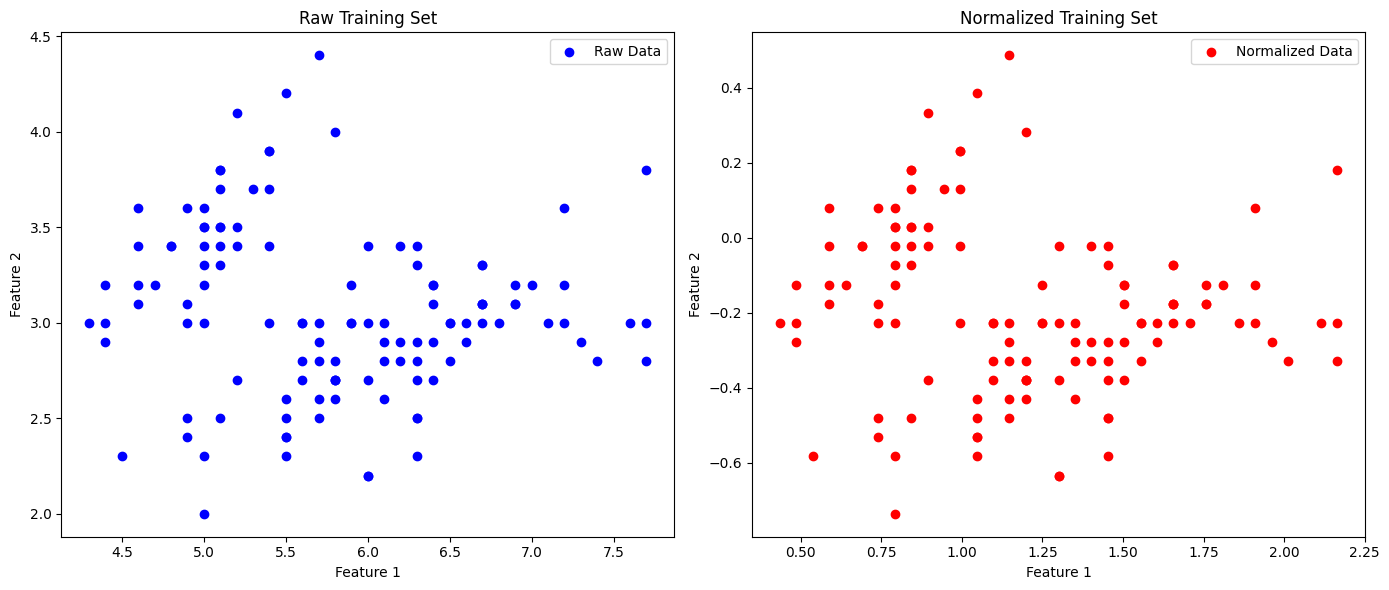

In [6]:



plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], color='blue', label="Raw Data")
plt.title('Raw Training Set')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()


plt.subplot(1, 2, 2)
plt.scatter(x_train_normalized[:, 0], x_train_normalized[:, 1], color='red', label="Normalized Data")
plt.title('Normalized Training Set')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

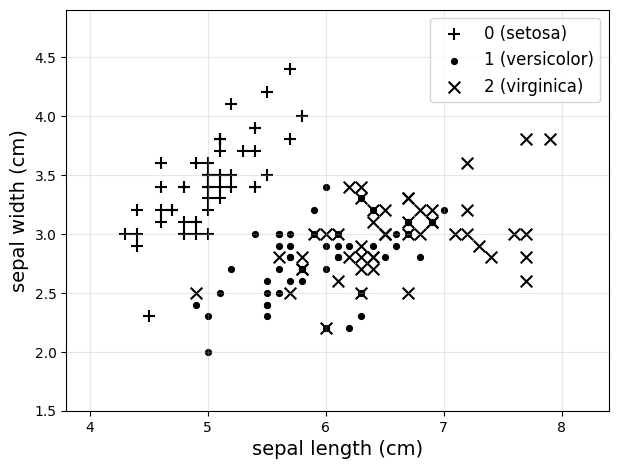

In [7]:
X = iris_db.data.iloc[:, :2]
Y = iris_db.target
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0],
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l],
      s=70,
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()

Is the data linearly separable?

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [8]:
train_set_1 = x_train_normalized[:, :2]
test_set_1 = x_test[:, :2]

# add a feature for bias
train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1)
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()

## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $

**Q2.** First implement the above function in `def sigmoid()`. [2 marks]

**Q3.** Then, using the implementation of `LinearRegression` from last week as guideline, create a custom pytorch layer for `LogisticRegression` [2 marks]

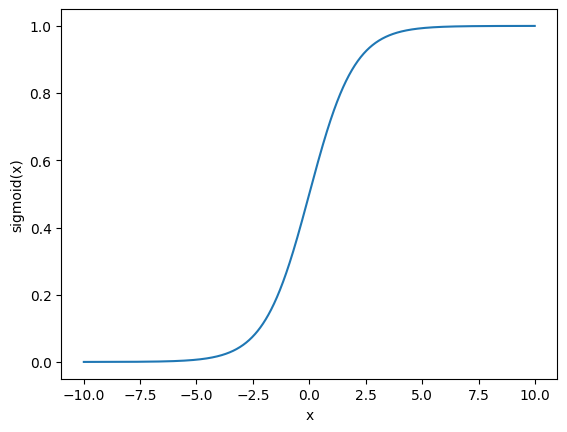

In [9]:
import math
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  ### your code here
  z = 1/ (1+ torch.exp(-z))
  return z


x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [10]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.ones(1, num_features), requires_grad=False)
    self.bias = nn.Parameter(torch.rand(1), requires_grad=False)  

  def forward(self, x):
    y = sigmoid(torch.matmul(x, self.weight.T) + self.bias)
    return y

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m}  \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$

**Q4.** Implement the cost in `bce()` and update the `gradient_descent_step()` from last week to update using the partial derivative above. [4 marks]

In [11]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    m = y_true.shape[0]  # number of samples
    # Logistic cost function
    cost = -(1 / m) * torch.sum((y_true * torch.log(y_pred ) )+ (1 - y_true) * torch.log(1 - y_pred))

    return cost
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  N = X.shape[0]
  # Calculate gradients for weight and bias
  weight_grad = (1 / N) * torch.matmul((y_pred - y).T, X)
  bias_grad = (1 / N) * torch.sum(y_pred - y)
  new_weight = model.weight - lr * weight_grad
  new_bias = model.bias - lr * bias_grad
  model.weight = nn.Parameter(new_weight, requires_grad=False)
  model.bias = nn.Parameter(new_bias, requires_grad=False)

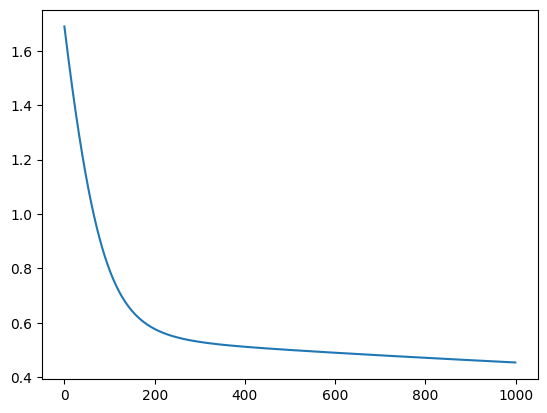

[tensor(1.6895), tensor(1.6759), tensor(1.6623), tensor(1.6489), tensor(1.6355), tensor(1.6222), tensor(1.6090), tensor(1.5959), tensor(1.5828), tensor(1.5699), tensor(1.5570), tensor(1.5442), tensor(1.5315), tensor(1.5189), tensor(1.5064), tensor(1.4940), tensor(1.4817), tensor(1.4694), tensor(1.4573), tensor(1.4452), tensor(1.4332), tensor(1.4214), tensor(1.4096), tensor(1.3979), tensor(1.3863), tensor(1.3749), tensor(1.3635), tensor(1.3522), tensor(1.3410), tensor(1.3299), tensor(1.3189), tensor(1.3080), tensor(1.2972), tensor(1.2865), tensor(1.2759), tensor(1.2655), tensor(1.2551), tensor(1.2448), tensor(1.2346), tensor(1.2245), tensor(1.2145), tensor(1.2047), tensor(1.1949), tensor(1.1852), tensor(1.1757), tensor(1.1662), tensor(1.1568), tensor(1.1476), tensor(1.1384), tensor(1.1294), tensor(1.1204), tensor(1.1116), tensor(1.1028), tensor(1.0942), tensor(1.0856), tensor(1.0772), tensor(1.0689), tensor(1.0606), tensor(1.0525), tensor(1.0445), tensor(1.0365), tensor(1.0287), tensor(

In [12]:
def train(model, x, y, alpha):
  cost_lst = list()
  for it in range(1000):
    prediction = model(x)
    cost = bce(y, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x, y, prediction, alpha)
  
  display.clear_output(wait=True)
  plt.plot(list(range(it+1)), cost_lst)
  plt.show()
  print(cost_lst)
  print(model.weight)
  print('Minimum cost: {}'.format(min(cost_lst)))

model = LogisticRegression(train_set_1.shape[1])
alpha = 0.01 # select an appropriate lr
train(model, train_set_1, setosa_train, alpha)

In [13]:
predictions = model(test_set_1)
rounded_preds = torch.round(predictions)
accuracy = (rounded_preds == setosa_test).float().mean()
print("Accuracy:", accuracy)

Accuracy: tensor(0.6667)


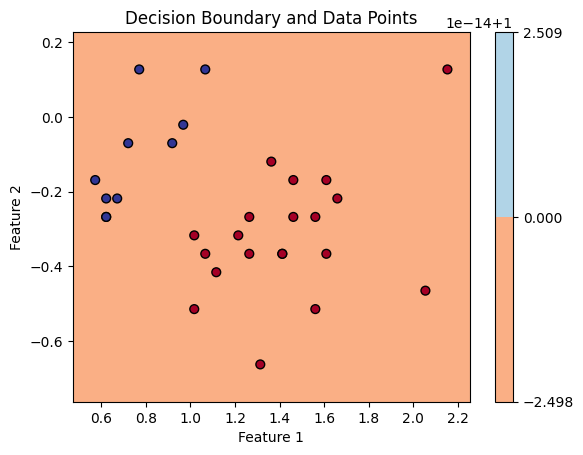

In [22]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")


    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()
    if model.weight.shape[1] > 2: 
        X_to_pred_on = torch.cat((X_to_pred_on, torch.zeros(X_to_pred_on.shape[0], 1)), dim=1)

    
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

 
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) 

    y_pred = y_pred.reshape(xx.shape).detach().numpy()

  
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.colorbar() 
    
    # Scatter the data points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary and Data Points")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

plot_decision_boundary(model, test_set_1, setosa_test)


<font color="red"> **Q5.** Draw the decision boundary on the test set using the learned parameters. Is this decision boundary separating the classes? Does this match our expectations? [2 marks]</font>

## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach (refer to the lecture notes for details). We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer.

In [15]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
print(y_test.shape)

torch.Size([30, 3])


In this section we will use the built in pytorch methods.


In [16]:
alpha = 0.1
setosa_model = nn.Sequential(nn.Linear(train_set_1.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))


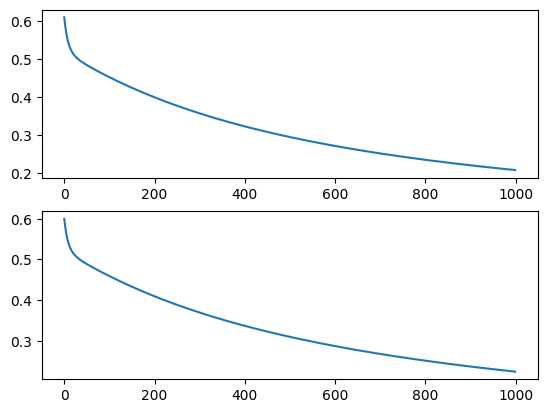

Minimum train cost: 0.2090713530778885
Minimum test cost: 0.22390587627887726


In [17]:
train(setosa_model, train_set_1, setosa_labels, test_set_1, setosa_testy, optimiser, alpha)

How does the cost of the 4 attribute model compare to the previous one?

**Q6** Now train classifiers for the other two classes.[1 mark]

Training Setosa Classifier


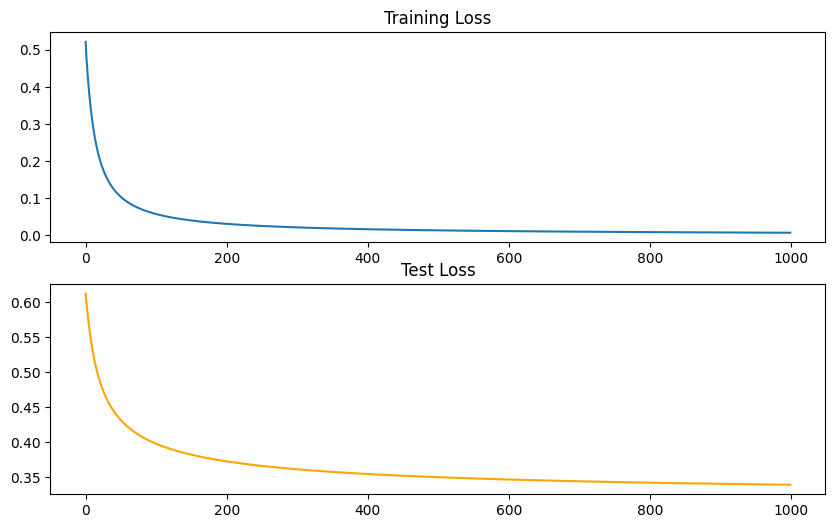

Minimum train cost: 0.0074
Minimum test cost: 0.3392
Training Versicolor Classifier


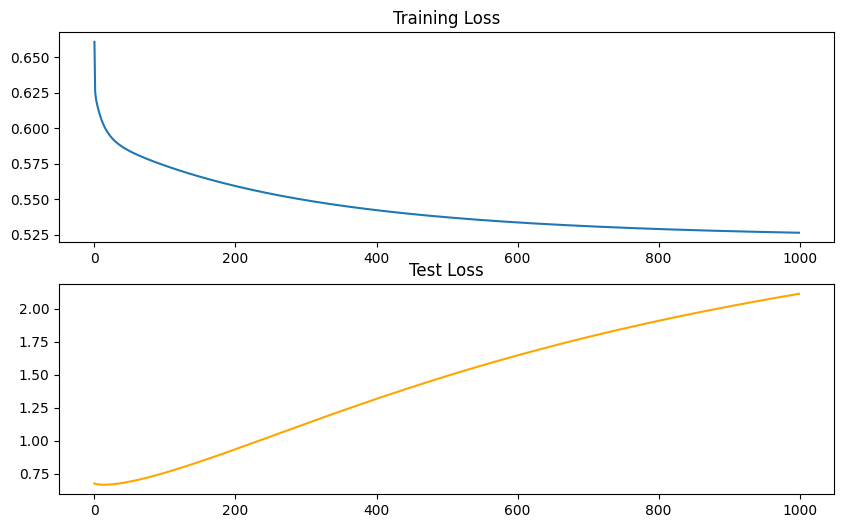

Minimum train cost: 0.5265
Minimum test cost: 0.6670
Training Virginica Classifier


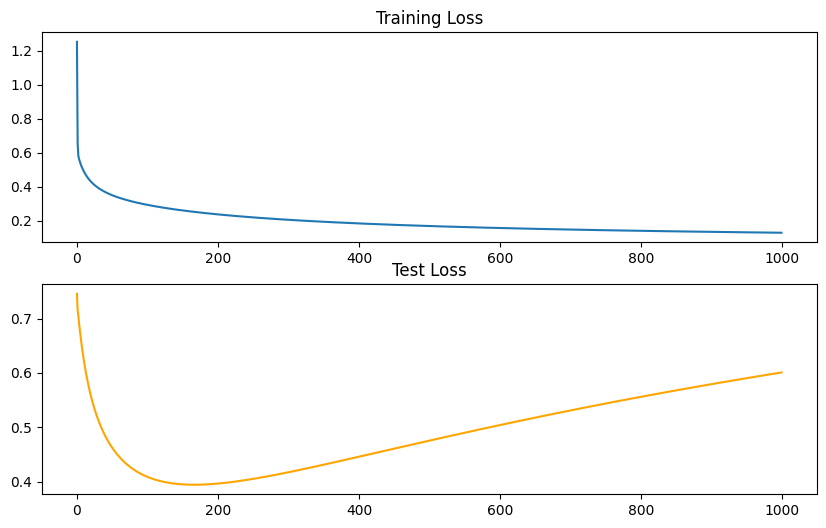

Minimum train cost: 0.1295
Minimum test cost: 0.3942


In [18]:

alpha = 0.1


def train(model, x, y, test_x, test_y, optimiser):
    train_lst = []
    test_lst = []
    for i in range(1000):
        model.train()
        optimiser.zero_grad()
        

        pred = model(x)
        cost = F.binary_cross_entropy(pred, y, reduction='mean')
        cost.backward()
        train_lst.append(cost.item())

        optimiser.step()

        model.eval()
        with torch.no_grad():
            test_pred = model(test_x)
            test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
            test_lst.append(test_cost.item())
    
    # Plot training and test losses
    fig, axs = plt.subplots(2, figsize=(10, 6))
    axs[0].plot(range(1000), train_lst, label='Training Loss')
    axs[1].plot(range(1000), test_lst, label='Test Loss', color='orange')
    axs[0].set_title('Training Loss')
    axs[1].set_title('Test Loss')
    plt.show()

    print('Minimum train cost: {:.4f}'.format(min(train_lst)))
    print('Minimum test cost: {:.4f}'.format(min(test_lst)))


# 1. Setosa
setosa_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
setosa_optimiser = optim.SGD(setosa_model.parameters(), lr=alpha)

print("Training Setosa Classifier")
train(setosa_model, x_train, setosa_labels, x_test, setosa_testy, setosa_optimiser)

# 2. Versicolor
versicolor_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
versicolor_labels = y_train[:, 1].reshape(-1, 1).float()
versicolor_testy = y_test[:, 1].reshape(-1, 1).float()
versicolor_optimiser = optim.SGD(versicolor_model.parameters(), lr=alpha)

print("Training Versicolor Classifier")
train(versicolor_model, x_train, versicolor_labels, x_test, versicolor_testy, versicolor_optimiser)

# 3. Virginica
virginica_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
virginica_labels = y_train[:, 2].reshape(-1, 1).float()
virginica_testy = y_test[:, 2].reshape(-1, 1).float()
virginica_optimiser = optim.SGD(virginica_model.parameters(), lr=alpha)

print("Training Virginica Classifier")
train(virginica_model, x_train, virginica_labels, x_test, virginica_testy, virginica_optimiser)


<font color="red"> **Q7.** Using the 3 classifiers, predict the classes of the samples in the test set and show the predictions in a table. Do you observe anything interesting? [4 marks] </font>

In [19]:
import pandas as pd


with torch.no_grad():
    setosa_preds = setosa_model(x_test).squeeze().numpy()
    versicolor_preds = versicolor_model(x_test).squeeze().numpy()
    virginica_preds = virginica_model(x_test).squeeze().numpy()


predictions_table = pd.DataFrame({
    'Setosa_Prob': setosa_preds,
    'Versicolor_Prob': versicolor_preds,
    'Virginica_Prob': virginica_preds,
    'True_Label': y_test.argmax(dim=1).numpy()  # Assuming y_test is one-hot encoded
})

predictions_table['Predicted_Class'] = predictions_table[['Setosa_Prob', 'Versicolor_Prob', 'Virginica_Prob']].idxmax(axis=1)


class_mapping = {'Setosa_Prob': 0, 'Versicolor_Prob': 1, 'Virginica_Prob': 2}
predictions_table['Predicted_Class'] = predictions_table['Predicted_Class'].map(class_mapping)

# Display the table
print(predictions_table[['Setosa_Prob', 'Versicolor_Prob', 'Virginica_Prob', 'True_Label', 'Predicted_Class']])


    Setosa_Prob  Versicolor_Prob  Virginica_Prob  True_Label  Predicted_Class
0      0.461537         0.972239        0.045352           1                1
1      0.995892         0.923930        0.000061           0                0
2      0.026882         0.983211        0.590959           2                1
3      0.508998         0.959865        0.047677           1                1
4      0.465869         0.976185        0.032339           1                1
5      0.995076         0.931917        0.000108           0                0
6      0.793631         0.950782        0.013869           1                1
7      0.315422         0.948969        0.097672           2                1
8      0.391214         0.979540        0.080506           1                1
9      0.703143         0.966144        0.019814           1                1
10     0.332476         0.947245        0.093230           2                1
11     0.993717         0.948840        0.000190           0    

<font color="red"> **Q8.** Calculate the accuracy of the classifier on the test set, by comparing the predicted values against the ground truth. Use a softmax for the classifier outputs. [1 mark] </font>

In [20]:
import torch
import torch.nn.functional as F

with torch.no_grad():
    setosa_preds = setosa_model(x_test).squeeze()
    versicolor_preds = versicolor_model(x_test).squeeze()
    virginica_preds = virginica_model(x_test).squeeze()
logits = torch.stack((setosa_preds, versicolor_preds, virginica_preds), dim=1)
probabilities = F.softmax(logits, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)
true_classes = y_test.argmax(dim=1) 
accuracy = (predicted_classes == true_classes).float().mean().item() * 100

# Display the accuracy
print(f"Accuracy on the test set: {accuracy:.2f}%")


Accuracy on the test set: 63.33%


## 3. The XOR problem

<font color="red"> **Q9.** Looking at the datapoints below, can we draw a decision boundary using Logistic Regression? Why? What are the specific issues or logistic regression with regards to XOR? [2 marks] </font>

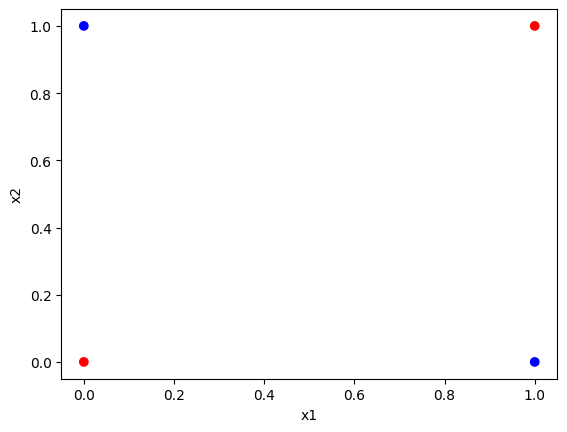

In [21]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()